In [1]:
import math
import os
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv(os.path.join('labeling', 'annotated-data', 'combined_negligence.csv'))
print(f"Number of labeled posts with perceived negligence: {df['PERCEIVED NEGLIGENCE'].sum()}")
print(f"Number of labeled posts: {len(df)}")

Number of labeled posts with perceived negligence: 240
Number of labeled posts: 1830


In [3]:
df = pd.read_csv(os.path.join('labeling', 'annotated-data', 'combined_disbelief.csv'))
print(f"Number of labeled posts with disbelief: {df['DISBELIEF'].sum()}")
print(f"Number of labeled posts: {len(df)}")

Number of labeled posts with disbelief: 132
Number of labeled posts: 1676


In [4]:
df = pd.read_csv(os.path.join('output', 'predictions', 'rel_raw_daily_freqs.csv'), index_col=0)
df['sym_rel_zscore'] = stats.zscore(df['symptoms_rel'])  # converting relative frequencies to z-scores
df['neg_rel_zscore'] = stats.zscore(df['negligance_rel'])
df['com_rel_zscore'] = stats.zscore(df['endo_comm_rel'])

In [5]:
n_after = len(df) // 2
n_before = len(df) - n_after
tags_list = []  # creating a list of Before and After tags to split dataset in two
for n in range(0,n_before):
    tags_list.append('Before')
for n in range(0,n_after):
    tags_list.append('After')
df['b_a'] = tags_list  # adding list to the dataframe as a column
df.head()

,date,total_count,predictions_DOCTORS,predictions_SYMPTOMS,predictions_ENDO-SUPPORT-COMMUNITY,predictions_PARTNER,predictions_FAMILY,predictions_PERCEIVED-NEGLIGENCE,doctors_rel,symptoms_rel,endo_comm_rel,partner_rel,family_rel,negligance_rel,sym_rel_zscore,neg_rel_zscore,com_rel_zscore,b_a
0,2012-01-23,5,0,1,2,0,0,0,0.0,0.200000,0.4,0.0,0.0,0.0,-2.073842,-0.7501,0.015777,Before
1,2012-01-28,5,1,2,1,0,0,0,0.2,0.400000,0.2,0.0,0.0,0.0,-1.041449,-0.7501,-0.975380,Before
2,2012-02-08,3,0,2,3,0,0,0,0.0,0.666667,1.0,0.0,0.0,0.0,0.335075,-0.7501,2.989250,Before
3,2012-02-12,1,0,1,1,0,0,0,0.0,1.000000,1.0,0.0,0.0,0.0,2.055729,-0.7501,2.989250,Before
4,2012-03-11,1,0,1,0,0,0,0,0.0,1.000000,0.0,0.0,0.0,0.0,2.055729,-0.7501,-1.966538,Before


In [6]:
def permute(input_array):
    # shuffle is inplace, so copy to preserve input
    permuted = input_array.copy().values  # convert to numpy array, avoiding warning
    np.random.shuffle(permuted)
    return pd.Series(permuted)  # convert back to pandas

In [7]:
def permutation_test(ddf, column):
    
    # Difference between the mean of the values in the first half and the mean of the values in the second half of the dataset
    real_mean_before = ddf.loc[ddf['b_a'] == 'Before'][column].mean()
    real_mean_after = ddf.loc[ddf['b_a'] == 'After'][column].mean()
    diff_real = real_mean_before - real_mean_after 
    
    # Performing 100,000 permutations
    n_permutations = 100000
    flag = 0
    for i in range(n_permutations):
        copy = ddf.copy()  # we copy the original dataframe with the observed data
        copy['b_a'] = permute(copy['b_a'])  # we shuffle the 'Before and After' column
        mean_before = copy.loc[copy['b_a'] == 'Before'][column].mean()
        mean_after = copy.loc[copy['b_a'] == 'After'][column].mean()
        diff_perm = mean_before - mean_after  # we calculate the difference between the means of the two halves of the dataset
        if diff_real > 0:  # if real difference is a positive number
            if diff_real > diff_perm:  # we test if the observed difference is greater
                flag += 1
        if diff_real < 0:  # if real difference is a positive number
            if diff_real < diff_perm:  # we test if the observed difference is lesser
                flag += 1  # we keep count of the number of times the observed difference is larger
    p = (n_permutations-flag)/n_permutations
    
    return diff_real, flag, p

In [9]:
# Permutation test on the difference between the daily relative occurence of the symptoms label
# in the first and second halves of the dataset
diff, flag_value, p_value = permutation_test(df, 'symptoms_rel')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}')

Observed difference: 0.036230521201026766
Number of times observed difference is larger than permutated: 100000
P-value: 0.0


In [10]:
# Permutation test on the difference between the daily relative occurence of the perceived negligence label
# in the first and second halves of the dataset
diff, flag_value, p_value = permutation_test(df, 'negligance_rel')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}')

Observed difference: -0.013940525935218925
Number of times observed difference is larger than permutated: 99987
P-value: 0.00013


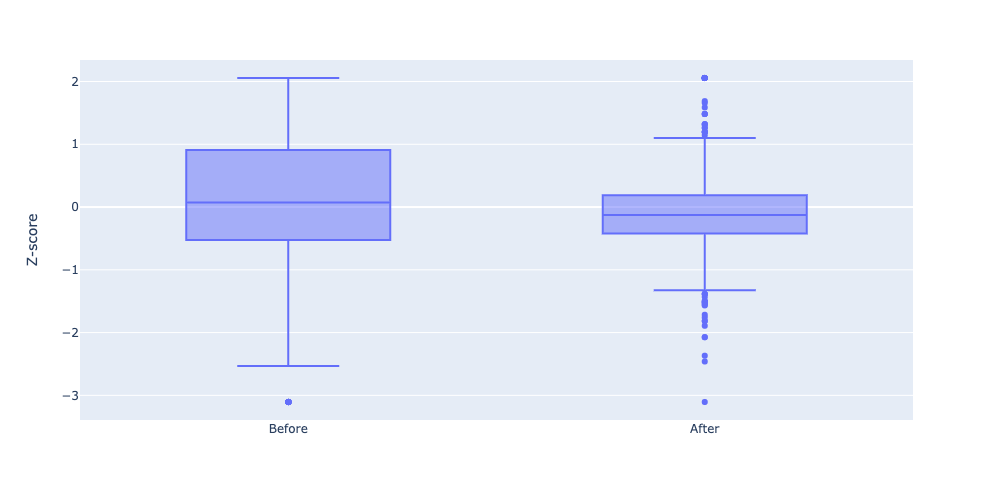

In [70]:
# Boxplots of zscores of the daily relative occurence of symptoms in the first and second half of the dataset
fig = px.box(df, x="b_a", y="sym_rel_zscore", width=500, height=500)
fig.update_xaxes(title='')
fig.update_yaxes(title='Z-score')
fig.show()

In [ ]:
# Boxplots of daily relative occurrences of symptoms in the first and second half of the dataset
fig = px.box(df, x="b_a", y="symptoms_rel", width=500, height=500)
fig.update_xaxes(title='')
fig.update_yaxes(title='Percentage of paragraphs per day')
fig.show()

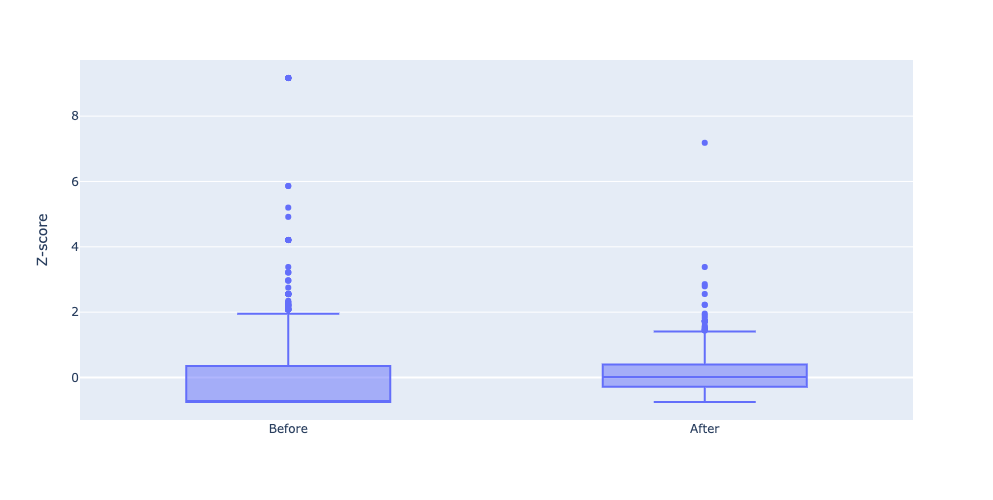

In [72]:
# Boxplots of zscores of the daily relative occurence of perceived negligence in the first and second half of the dataset
fig = px.box(df, x="b_a", y="neg_rel_zscore", width=500, height=500)
fig.update_xaxes(title='')
fig.update_yaxes(title='Z-score')
fig.show()

In [ ]:
# Boxplots of daily relative occurrences of perceived negligence in the first and second half of the dataset
fig = px.box(df, x="b_a", y="negligance_rel", width=500, height=500)
fig.update_xaxes(title='')
fig.update_yaxes(title='Percentage of paragraphs per day')
fig.show()

In [ ]:
# Boxplots of zscores of the daily relative occurence of endo-community in the first and second half of the dataset
fig = px.box(df, x="b_a", y="com_rel_zscore", width=500, height=500)
fig.update_xaxes(title='')
fig.update_yaxes(title='Z-score')
fig.show()

In [ ]:
# Boxplots of daily relative occurrences of endo-community in the first and second half of the dataset
fig = px.box(df, x="b_a", y="endo_comm_rel", width=500, height=500)
fig.update_xaxes(title='')
fig.update_yaxes(title='Percentage of paragraphs per day')
fig.show()

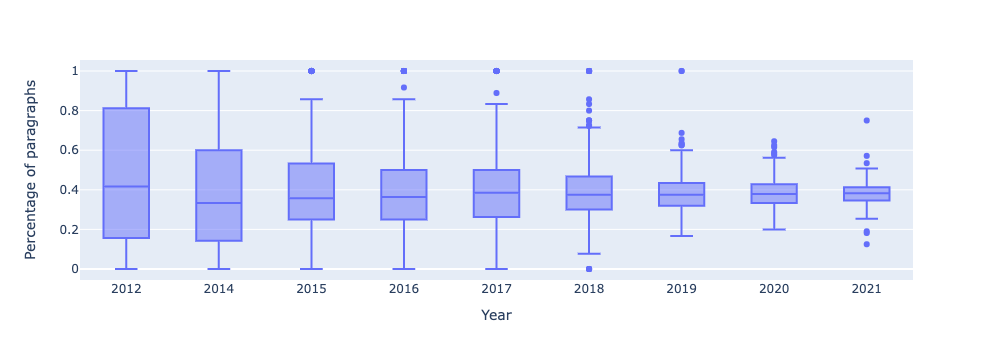

In [11]:
# Boxplots of daily relative occurrences of endo-community over time
df['year'] = df['date'].apply(lambda x: str(x).split('-')[0])
fig = px.box(df, x="year", y='endo_comm_rel')
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Percentage of paragraphs')
fig.show()